(ws4_solution)=
# WS 4 Solution 📈

:::{epigraph}
Regression and causal graphs

-- TODO your name here
:::

:::{admonition} Collaboration Statement
- TODO brief statement on the nature of your collaboration.
- TODO your collaborator's names here
:::

# Learning Objectives

- Become familiar with the `statsmodels` library for running regression models
- Understand the relationship between the regression coefficient for a treatment variable and the average treatment effect
- Practice determining when adjustment is needed vs when it is not given a DAG
- Read and reflect on a technical article introducing propensity scores as an observational study technique

# 1. Statsmodels [1 pt]

[statsmodels](https://www.statsmodels.org/stable/index.html) is a popular Python library for statistical modeling and analysis. It provides a wide range of statistical models and functions similar to what you might find in R. We'll use statsmodels throughout the worksheet and in the upcoming classes to fit regression models.

Like matplotlib and seaborn, statsmodels has an extensive API with many different ways to achieve the same result. For the course, we'll work primarily with the `formula.api` submodule for integration with pandas DataFrames and the [patsy](https://patsy.readthedocs.io/en/latest/) syntax for specifying regression formulas. The following official user guide is a good starting reference for how we'll primarily be using statsmodels:

- [Fitting models using R-style formulas](https://www.statsmodels.org/stable/example_formulas.html)

First, let's import the statsmodels library using the standard alias `smf` (**s**tats**m**odels **f**ormula) for the formula API, along with the other data science modules we have been using:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact_manual

# standard import alias for the statsmodels formula API
import statsmodels.formula.api as smf

## Using statsmodels to fit linear regression models

Up until this point in class, we have been estimating various versions of conditional expectations of the form:

$$
E[Y | X]
$$


For example, we have calculated the conditional expectation of the outcome given a particular treatment value $t$:

$$
\hat{E}[Y | T=t]
$$

As well as the conditional expectation of the outcome given particular treatment and covariate values $t$ and $x$:

$$
\hat{E}[Y | T=t, X=x]
$$



These are all useful calculations, but they only tell us about the conditional expectation of the outcome given particular treatment and covariate values. What if $X$ was continuous, and we wanted to know the effect of $T$ on $Y$ across all values of $X$?

This is where **line fitting** via linear regression is useful. Under certain statistical assumptions, we can actually model the conditional expectation. Fitting the following linear regression model, where the $\beta$ values are the **regression coefficients** that we will estimate from our data:

$$
Y= \beta_0 + \beta_1 T
$$

actually gives us the following estimated conditional expectation:

$$
E[Y | T] = \beta_0 + \beta_1 T
$$


And if we have multiple covariates, we can fit the following model:

$$
Y= \beta_0 + \beta_1 T + \beta_2 X
$$

which gives us the following conditional expectation:

$$
E[Y | T, X] = \beta_0 + \beta_1 T + \beta_2 X
$$

When we set the covariates to particular $T=t$ and $X=x$ values, we get the conditional expectation of the outcome given those values:

$$
E[Y | T=t] = \beta_0 + \beta_1 t
$$


$$
E[Y | T=t, X=x] = \beta_0 + \beta_1 t + \beta_2 x
$$



:::{note}

Unlike the causal study design assumptions we have been discussing, we won't cover the assumptions that make linear regression a valid model for the conditional expectations. For now, we'll take linear regression correctly modelling conditional expectations as a given and focus on how to fit and interpret the regression coefficients. If you are curious and want to learn more about the properties of linear regression, see the following resource:

- [Chapters 2.11 - 2.25](https://mixtape.scunning.com/02-probability_and_regression#population-model) of Causal Inference: The Mixtape

:::



Let's take a look at how to use statsmodels to fit a line to some data. We'll load in the same gapminder data from Worksheet 3 and fit a line to the relationship between life expectancy and GDP per capita for countries in Europe in 2007.


### 1.1

First, let's select the data for Europe in 2007 and visualize the relationship between life expectancy `lifeExp` and GDP per capita `gdpPercap` using a scatter plot. The data should roughly follow a linear relationship, with some spread:

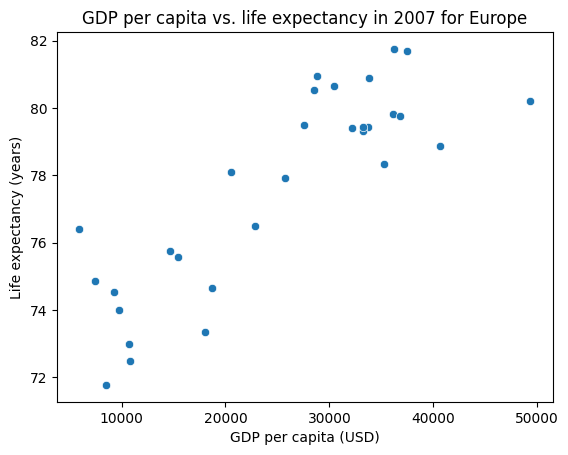

In [3]:
gapminder_df = pd.read_csv("~/COMSC-341CD/data/gapminder.csv")

# TODO select the gapminder data for Europe in 2007
selected_df = None

### BEGIN SOLUTION
selected_df = gapminder_df[gapminder_df["year"] == 2007]
selected_df = selected_df[selected_df["continent"] == "Europe"]
### END SOLUTION

# TODO show the scatter plot between 'gdpPercap' and 'lifeExp'

### BEGIN SOLUTION
sns.scatterplot(data=selected_df, x="gdpPercap", y="lifeExp")
plt.title("GDP per capita vs. life expectancy in 2007 for Europe")
plt.xlabel("GDP per capita (USD)")
plt.ylabel("Life expectancy (years)")
plt.show()
### END SOLUTION


Let's now fit a line to this data using a statsmodels formula.

We can specify the linear regression we want to fit using a string describing the formula. The formula is specified in the format: 

```
'outcome ~ 1 + covariate1 + covariate2 + ...'
```

where:

-  `outcome` is the dependent variable (the outcome or "y" we want to predict)
-  `1` is the constant term (the intercept)
-  `covariate1`, `covariate2`, etc. are the independent variables (the "x"s we use to predict the outcome)


This string formula is then passed into the `smf.ols` (**o**rdinary **l**east **s**quares) function to fit the model. What is convenient is that we can pass in the pandas DataFrame containing the data directly to the function as the `data` argument, and the formula will be applied to the DataFrame column names. For example, if we have a DataFrame `df` with columns `y`, `x1`, and `x2`, the formula `'y ~ 1 + x1 + x2'` will fit a linear regression model with those columns to the data. The code that corresponds to this is:

```python
formula  = 'y ~ 1 + x1 + x2'
linear_reg_results = smf.ols(formula, data=df).fit()
```

Let's try this out on our gapminder data:

- `lifeExp` is the outcome variable
- `gdpPercap` is the independent variable
- include a constant term in the model by adding a `1` to the formula


In [4]:
# TODO fit the linear regression model with the formula above
formula = ''
linear_reg_results = None

### BEGIN SOLUTION
formula = 'lifeExp ~ 1 + gdpPercap'
linear_reg_results = smf.ols(formula, data=selected_df).fit()
### END SOLUTION

We can examine the fitted $\beta$ values using the `params` attribute of the fitted model object, which returns a pd.Series of the coefficients:


In [5]:
# TODO print the fitted coefficients
# print(linear_reg_results.params)

We can also call the `predict()` method on the fitted model object to get predictions on a DataFrame of values that match the column names in the original data. 

Let's apply this to a range of GDP per capita values to get the fitted life expectancy values to plot the fitted line. Use the [np.linspace](https://numpy.org/doc/2.1/reference/generated/numpy.linspace.html) function to generate a list of `num=1000` evenly spaced values, starting at the minimum and ending at the maximum GDP per capita `gdpPercap` values in the data.

In [6]:
# TODO generate evenly spaced values
# x_values = np.linspace(start=TODO, stop=TODO, num=TODO)

# TODO save the predicted values, using the same column name as the original data
# y_values = linear_reg_results.predict(
#     pd.DataFrame({"gdpPercap": x_values})
# )

### BEGIN SOLUTION
x_values = np.linspace(start=selected_df["gdpPercap"].min(), stop=selected_df["gdpPercap"].max(), num=1000)
y_values = linear_reg_results.predict(pd.DataFrame({"gdpPercap": x_values}))
### END SOLUTION

Finally, let's visualize the scatter plot of the original data and the fitted line on the same plot.

We can use the `sns.lineplot()` function to plot the fitted line, passing in the `x_values` and `y_values` as the `x` and `y` arguments respectively.

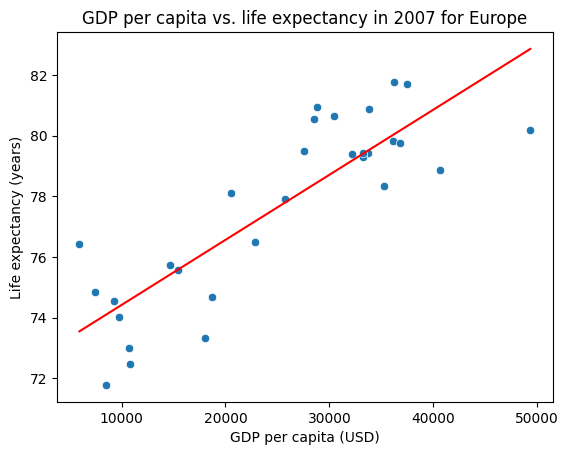

In [7]:
# TODO plot the original data and the fitted line
### BEGIN SOLUTION
sns.scatterplot(data=selected_df, x="gdpPercap", y="lifeExp")
sns.lineplot(x=x_values, y=y_values, color="red")
plt.title("GDP per capita vs. life expectancy in 2007 for Europe")
plt.xlabel("GDP per capita (USD)")
plt.ylabel("Life expectancy (years)")
plt.show()
plt.show()
### END SOLUTION


## Interpreting regression coefficients

### 1.2

In order to use linear regression for causal inference, we'll need to pay close attention to the interpretation of the regression coefficients.

In general, the regression coefficient $\beta_1$ for a covariate $X_1$ can be interpreted as the expected change in the outcome $Y$ for a **one unit change** in $X_1$, holding all other covariates constant.

For example, suppose we have a linear regression model fitting the relationship between coffee price $Y$ in dollars per pound (\$/lb) and global temperature in celcius $X_1$ and coffee species $X_2$ (0 = robusta, 1 = arabica):

$$
Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2
$$

The regression coefficient $\beta_1$ can be interpreted as the associated expected change in coffee price $Y$ for a **one degree Celsius increase** in global temperature $X_1$, holding the coffee species $X_2$ constant. If $\beta_1 = 3$, we can interpret this as: 

> In the collected data, the price of coffee is associated with an increase of $3 per pound for each degree Celsius increase in global temperature, while holding the coffee species constant.


Since a fitted regression is linear, we can also scale the units of $X_1$ to be different. For example, we could interpret $2*\beta_1$ as the associated expected change in coffee price $Y$ for a **two degree Celsius increase** in global temperature $X_1$, holding the coffee species $X_2$ constant, or even convert the units to Fahrenheit in stead of Celsius.

Let's now interpret the regression coefficients for our gapminder data. Multiply the `gdpPercap` coefficient by 1000 to convert the units to thousands of dollars, and interpret the new coefficient for the `gdpPercap` variable. In your response, be sure to include the year and selected continent of the data used to fit the model.

**Your Response**: For European countries in 2007, a $1000 increase in GDP per capita is associated with a 0.215 year increase in life expectancy.

In [8]:
# TODO use this cell to scale the gdpPercap coefficient by 1000 and interpret the new coefficient

### BEGIN SOLUTION
print(linear_reg_results.params["gdpPercap"]*1000)
### END SOLUTION


0.2146340344675849


### 1.3

A common transformation applied to variables in linear regression models is to take the natural logarithm of the variable, which does two things:

- it often helps make the variables "better-behaved" (e.g. more like a normal distribution)
- it also changes the interpretation of the regression coefficients.

Let's apply this transformation to the `gdpPercap` and `lifeExp` variables, and interpret the new regression coefficients.

First, create new columns in the  **full** `gapminder_df` DataFrame containing the log-transformed variables by applying the `np.log()` function to the `gdpPercap` and `lifeExp` columns:


In [9]:
# TODO create new columns in the original gapminder_df DataFrame containing the log-transformed variables
gapminder_df['log_gdpPercap'] = None
gapminder_df['log_lifeExp'] = None

### BEGIN SOLUTION
gapminder_df['log_gdpPercap'] = np.log(gapminder_df['gdpPercap'])
gapminder_df['log_lifeExp'] = np.log(gapminder_df['lifeExp'])
### END SOLUTION


Next, let's plot the histograms of the original and log-transformed 'gdpPercap' side-by-side to to see the effect of the transformation.

To create the side-by-side plot, we use the [plt.subplots()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) function to create a figure with two subplots. This function has many optional arguments for figure size, layout, etc. that we can use to customize the plot, but the primary arguments we need to specify are:

- `nrows`: the number of rows in the figure
- `ncols`: the number of columns in the figure
- `figsize`: the size of the figure, which takes a tuple of the figure `(width, height)` in inches

This then returns a `(fig, axs)` tuple, where `fig` is the figure object and `axs` is an array of the axes objects. 
We can think of the `fig` object as the overall figure, and the `axs` array corresponding to the individual subplots.

For example, if we want to create a figure with 1 row and 2 columns, we can make the following `plt.subplots()` call. Then, we can plot on the first subplot using `axs[0]` and the second subplot using `axs[1]`, as well as set the title and axis labels for each subplot:

number of subplots: 2


Text(0.5, 0.98, 'Overall title for the figure')

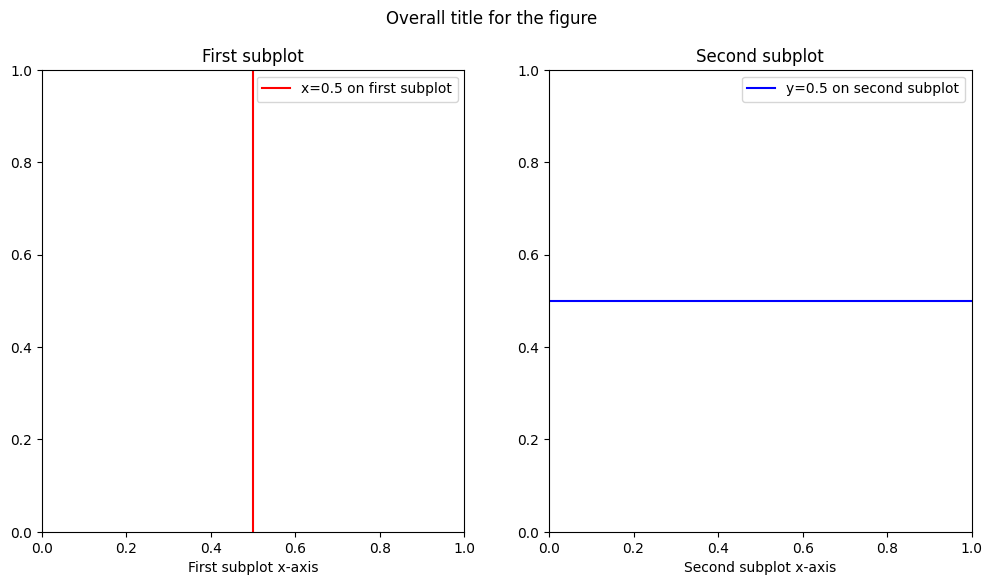

In [10]:
# TODO run this cell to see an example of the `plt.subplots()` function
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
print("number of subplots:", len(axs))

# axs[0] is the first (left) subplot, axs[1] is the second (right) subplot
axs[0].axvline(x=0.5, label="x=0.5 on first subplot", color="red")
axs[1].axhline(y=0.5, label="y=0.5 on second subplot", color="blue")

# We can individually set the title and axis labels for each subplot
axs[0].set_title("First subplot")
axs[1].set_title("Second subplot")
axs[0].set_xlabel("First subplot x-axis")
axs[1].set_xlabel("Second subplot x-axis")
axs[0].legend()
axs[1].legend()

# We can also set the title for the entire figure 
fig.suptitle("Overall title for the figure")


Seaborn again provides convenient intergration with matplotlib, as most seaborn plotting functions have an optional `ax` argument that we can use to plot on a specific axis.

Let's create the side-by-side plot of the histograms of the original and log-transformed 'gdpPercap' variables using
[sns.histplot()](https://seaborn.pydata.org/generated/seaborn.histplot.html) and the `ax` argument to plot on specific axes. The tranformed data should look more "normally distributed" than the original data.

Text(0.5, 0.98, 'GDP per capita for all countries')

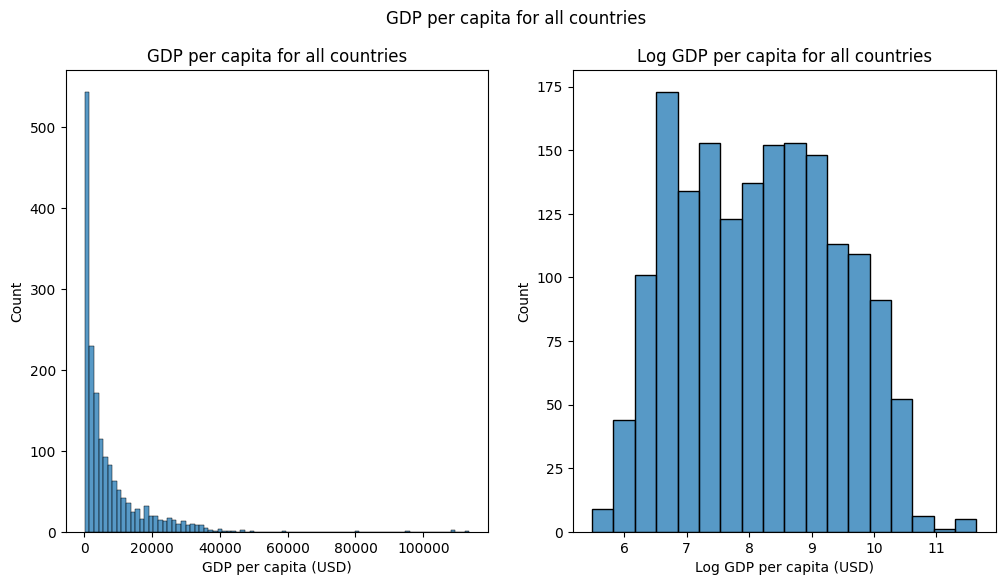

In [11]:
# TODO generate subplots with 1 row and 2 columns, figsize=(12,6)
# fig, axs = plt.subplots(nrows=None, ncols=None, figsize=None)

# TODO plot the histograms of the original 'gdpPercap' variable on the first subplot by using the `ax` argument
# sns.histplot(x=TODO, ax=TODO)

# TODO plot the histogram of the log-transformed 'log_gdpPercap' variable on the second subplot by using the `ax` argument
# sns.histplot(x=TODO, ax=TODO)


### BEGIN SOLUTION
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
sns.histplot(gapminder_df['gdpPercap'], ax=ax1)
sns.histplot(gapminder_df['log_gdpPercap'], ax=ax2)
ax1.set_xlabel("GDP per capita (USD)")
ax2.set_xlabel("Log GDP per capita (USD)")
ax1.set_title("GDP per capita for all countries")
ax2.set_title("Log GDP per capita for all countries")
fig.suptitle("GDP per capita for all countries")
### END SOLUTION

### 1.4

Let's now fit a linear regression model to the log-transformed data. When both the outcome and covariate are log-transformed, the regression coefficient can be interpreted as approximately the **percentage change** in the outcome for a **one percent change** in the covariate (this is also known as the **elasticity** in economics). For example, in our coffee price example above, if we instead fit the model:

$$
\log(Y) = \beta_0 + \beta_1 \log(X_1) + \beta_2 X_2
$$

And $\beta_1 = 2.5$, we can interpret this as:

> In the collected data, the price of coffee is associated with a price per pound increase of 2.5% for each 1% increase in global temperature, while holding the coffee species constant.

Let's now fit a linear regression model to the log-transformed data and interpret the regression coefficients. Specifically, fit the model on the entire `gapminder_df` DataFrame, and interpret the regression coefficient for the `log_gdpPercap` variable:

$$
\log(\text{lifeExp}) = \beta_0 + \beta_1 \log(\text{gdpPercap})
$$

**Your Response**: Among all countries in the gapminder dataset across all years, an 1% increase in GDP per capita is associated with a 0.15% increase in life expectancy.


In [12]:
# TODO fit the linear regression model to the log-transformed data
log_formula = ''
log_reg_results = None

### BEGIN SOLUTION
log_formula = 'log_lifeExp ~ 1 + log_gdpPercap'
log_reg_results = smf.ols(log_formula, data=gapminder_df).fit()
print(log_reg_results.params)
### END SOLUTION

Intercept        2.864177
log_gdpPercap    0.146549
dtype: float64


# 2. Linear regression for treatment effect estimation [1 pt]


Now that we have seen how to fit linear regression models and interpret the regression coefficients, let's see how we can use linear regression to estimate causal effects. An advantage of linear regression for estimating causal effects is that it makes "controlling for" many covariates straightforward. For example, if we have a treatment variable $T$ and a set of variables $X = \{X_1, X_2, X_3 \}$ that satisfies the backdoor criterion we want to control for, we can fit the model:

$$
Y = \beta_0 + \beta_1 T + \beta_2 X_1 + \beta_3 X_2 + \beta_4 X_3
$$

This generalizes to any number of covariates (though we still need to be careful about positivity violations!).

### 2.1

First, let's write a general function that fits a linear regression model to the data with a given treatment variable and covariates list, and returns the fitted model results object.

In [13]:
def fit_linear_regression(data, outcome, treatment, covariates=None):
    """
    Fit a linear regression model to the data with a given treatment variable and optional covariates list,
    returning the fitted coefficients.

    Assumes that the treatment column is binary, and that the covariates are all continuous.

    Args:
        data (pd.DataFrame): The data to fit the model to.
        outcome (str): The outcome variable.
        treatment (str): The treatment variable.
        covariates (list[str]): The covariates to control for, defaults to None

    Returns:
        smf.OLSResults: The fitted model results object, which is the output of the `smf.ols()` function
    """
    assert outcome in data.columns, "Outcome variable not found in data"
    assert treatment in data.columns, "Treatment variable not found in data"

    # TODO complete this function, be sure to handle the case where covariates is None!
    pass

    ### BEGIN SOLUTION
    if covariates is None:
        formula = f"{outcome} ~ 1 + {treatment}"
    else:
        formula = f"{outcome} ~ 1 + {treatment} + {' + '.join(covariates)}"
    return smf.ols(formula, data=data).fit()
    ### END SOLUTION



Let's now look at the relationship between the regression coefficient for our binary treatment variable and the difference-in-means estimate we've been looking at so far in the course. Below is a simplified version of the `sim_random_experiment()` function we used in Project 1, which simulates a random experiment with a binary treatment variable and a continuous outcome variable and returns a dataframe with the outcome and treatment variables:

In [14]:
rng = np.random.default_rng(seed=42)

def sim_random_experiment(n_samples=300, treatment_effect=1.0):
    """
    Simulate a random experiment with a binary treatment.

    Args:
        n_samples (int): the number of samples to simulate
        treatment_effect (float): the magnitude of the effect of the treatment on the outcome

    Returns:
        pd.DataFrame: a dataframe with the outcome and treatment variables:
            - Y: the observed outcome
            - T: the binary treatment assignment
    """
    # Generate potential outcomes
    Y0 = rng.normal(size=n_samples)
    Y1 = Y0 + treatment_effect

    # Randomly assign treatment
    T = rng.choice([0, 1], size=n_samples)
    # Generate the observed outcome
    Y = np.where(T == 1, Y1, Y0)

    return pd.DataFrame({"Y": Y, "T": T})

### 2.2

We'll begin by visualizing the data generated by the `sim_random_experiment()` function using a [sns.swarmplot()](https://seaborn.pydata.org/generated/seaborn.swarmplot.html), which is similar to a categorical [sns.scatterplot()](https://seaborn.pydata.org/generated/seaborn.scatterplot.html) but ensures that the points are not overlapping to better visualize the distribution. Specifically, for the swarmplot, set the `x` argument to the treatment variable `T` to visualize the distribution of the outcome `Y` by treatment assignment, and set the `hue` argument to the treatment variable `T` to color the points by treatment assignment. The alpha argument is set to 0.5 to make the points more transparent.

Additionally, annotate the plot with the mean of the outcome for the treatment and control groups. This should be two horizontal lines, which can be done using the `ax.axhline()` function.


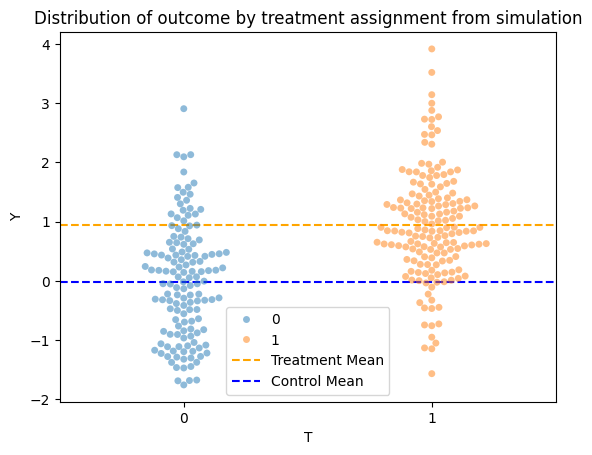

In [15]:
data = sim_random_experiment()
# TODO generate the swarmplot
# sns.swarmplot(data=data, x=TODO, y=TODO, hue=TODO, alpha=0.5)

# TODO annotate the plot with the mean of the outcome for the treatment and control groups
# plt.axhline(y=TODO, color='orange', label=TODO)
# plt.axhline(y=TODO, color='blue', label=TODO)

### BEGIN SOLUTION
sns.swarmplot(data=data, x="T", y="Y", hue="T", alpha=0.5)
plt.title("Distribution of outcome by treatment assignment from simulation")
plt.axhline(y=data["Y"][data["T"] == 1].mean(), color='orange', linestyle='--', label='Treatment Mean')
plt.axhline(y=data["Y"][data["T"] == 0].mean(), color='blue', linestyle='--', label='Control Mean')
plt.legend()
plt.show()
### END SOLUTION


Next, use your `fit_linear_regression()` function to fit a linear regression model to the simulated data, and plot the fitted line on the swarmplot:

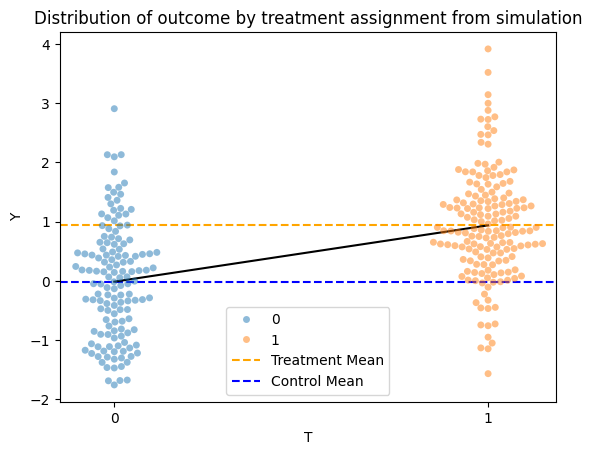

In [16]:
# TODO fit the linear regression model
treat_reg_results = None

# TODO predict on T=0 and T=1
x_values = [0, 1]
x_df = pd.DataFrame({"T": x_values})
y_values = None

# TODO plot the fitted line on the swarmplot -- you can copy the code from above into this cell

### BEGIN SOLUTION
treat_reg_results = fit_linear_regression(data, outcome="Y", treatment="T")
x_df = pd.DataFrame({"T": [0, 1]})
y_values = treat_reg_results.predict(x_df)

sns.swarmplot(data=data, x="T", y="Y", hue="T", alpha=0.5)
plt.title("Distribution of outcome by treatment assignment from simulation")
plt.axhline(y=data["Y"][data["T"] == 1].mean(), color='orange', linestyle='--', label='Treatment Mean')
plt.axhline(y=data["Y"][data["T"] == 0].mean(), color='blue', linestyle='--', label='Control Mean')
sns.lineplot(x=x_df["T"], y=y_values, color="black")
plt.legend()
plt.show()


# sns.lineplot(x="T", y="Y", data=data, color="red")
# plt.show()
### END SOLUTION



Finally, copy your plotting code from above and add an `interact_manual` decorator to the `plot_treat_regression` function below. Specifically, add a slider to control the `treatment_effect` parameter with a range from -5 to 5:

In [17]:
# TODO add an interactive_manual decorator to the `plot_treat_regression` function
### BEGIN SOLUTION
@interact_manual(treatment_effect=(-5, 5, 0.1))
### END SOLUTION
def plot_treat_regression(treatment_effect):
    data = sim_random_experiment(treatment_effect=treatment_effect)

    # TODO copy your plotting code from above into this cell

    ### BEGIN SOLUTION
    # TODO fit the linear regression model
    treat_reg_results = None

    # TODO predict on T=0 and T=1
    x_values = [0, 1]
    x_df = pd.DataFrame({"T": x_values})
    y_values = None

    treat_reg_results = fit_linear_regression(data, outcome="Y", treatment="T")
    x_df = pd.DataFrame({"T": [0, 1]})
    y_values = treat_reg_results.predict(x_df)

    sns.swarmplot(data=data, x="T", y="Y", hue="T", alpha=0.5)
    plt.title("Distribution of outcome by treatment assignment from simulation")
    plt.axhline(y=data["Y"][data["T"] == 1].mean(), color='orange', linestyle='--', label='Treatment Mean')
    plt.axhline(y=data["Y"][data["T"] == 0].mean(), color='blue', linestyle='--', label='Control Mean')
    sns.lineplot(x=x_df["T"], y=y_values, color="black")
    plt.legend()
    plt.show()
    ### END SOLUTION

interactive(children=(FloatSlider(value=0.0, description='treatment_effect', max=5.0, min=-5.0), Button(descri…

The linear regression model we've fitted is:

$$
E[Y | T] = \beta_0 + \beta_1 T
$$

$\beta_1$ is the regression coefficient for the treatment variable $T$ and can also be interpreted as the slope of the line we've fitted. After trying out different values of the `treatment_effect` parameter in your interactive plot above, what relationship do you see between the slope of the line and the two means in the plot? What does this tell us about the relationship between the regression coefficient and the difference-in-means estimate?

**Your Response**: In the interactive plot, the slope of the line is equal to difference-in-means estimate of the treatment effect, which corresponds to $\beta_1$ in the model we've fitted.


:::{admonition} Takeaway (click this once you've completed the section)
:class: dropdown

This now ties back to our interpretation of the regression coefficient in part 1 of the worksheet -- the regression coefficient $\beta_1$ can be interpreted as the change in the outcome for a one unit change in the treatment, holding all other variables constant. Since the treatment is binary, a one unit change in the treatment is from 0 to 1, so the regression coefficient is equal to the difference in the outcome between the treatment and control groups.

:::

:::{admonition} Math derivation (click this once you've completed the section)
:class: dropdown

If we assume the same assumptions that allow for identification of the causal effect in a randomized experiment, and we assume that we can model the conditional expectation of the outcome given the treatment as:

$$
E[Y | T] = \beta_0 + \beta_1 T
$$

then the regression coefficient $\beta_1$ is equal to the ATE: $E[Y(1) - Y(0)]$.

To see this, we have:

$$
E[Y(1)] = E[Y(1) | T=1] = E[Y | T=1] \\
E[Y(0)] = E[Y(0) | T=0] = E[Y | T=0]
$$

then plugging in the regression model, we get:

$$
\begin{align*}
E[Y | T=1] &= \beta_0 + \beta_1 \times 1 = \beta_0 + \beta_1 \\
E[Y | T=0] &= \beta_0 + \beta_1 \times 0 = \beta_0
\end{align*}
$$

Finally, plugging in those values for the ATE, we get:

$$
ATE = E[Y(1) - Y(0)] = E[Y(1)] - E[Y(0)] = (\beta_0 + \beta_1) - \beta_0 = \beta_1
$$






:::

# 3. To adjust or not to adjust? [1.5 pts]

Let's now utilize linear regression to control for multiple convariates, and practice determining which covariates to adjust for via the backdoor criterion. To do so, we'll analyze some toy datasets generated from different DAGs. Since the datasets have been simulated, the true treatment effects are known -- work through the following questions before clicking the dropdown at the end of the section to check whether you got the treatment effect estimates correct.

### 3.1

Here is our first DAG that we'll analyze:

![](../images/ws4_dag1.png)

Using the `fit_linear_regression()` function you wrote in the previous section, fit a linear regression model with the specified covariates:



What is the estimated ATE if we fit a linear regression model with just the treatment and outcome?

**Your Response**: The estimated ATE is -0.85 when only using treatment to fit the outcome.

What variables satisfy the backdoor criterion and should we adjust for? Adjust for these by including them in the `covariates` argument of the `fit_linear_regression()` function. What is your estimated ATE when including these variables?

**Your Response**: We need to adjust for X1, X2, X3, and **not** adjust for X4. If we only include X1, X2, and X3 the estimated ATE is -4.99.

What variable(s) should we not adjust for? Identify what kind of variable(s) they are (mediator, collider, or confounder). What is the estimated ATE if you include these variable(s) in the adjustment set as well?

**Your Response**: X4 is a collider, so we should not adjust for it. If we include X4 in our adjustment set, the estimated ATE shifts to -3.01.


In [18]:
dag1_df = pd.read_csv("~/COMSC-341CD/data/ws4_dag1.csv")

# TODO use `fit_linear_regression()` to fit a linear regression model with just the treatment and outcome
#print(fit_linear_regression(data=dag1_df, outcome="Y", treatment="T").params)

# TODO use `fit_linear_regression()` to fit a linear regression model with the treatment, outcome, and correct adjustment set

# TODO use `fit_linear_regression()` to fit a linear regression model with the treatment, outcome, and incorrect adjustment set

### BEGIN SOLUTION
print(fit_linear_regression(data=dag1_df, outcome="Y", treatment="T").params)
print(fit_linear_regression(data=dag1_df, outcome="Y", treatment="T", covariates=['X2', 'X3', 'X1']).params)
print(fit_linear_regression(data=dag1_df, outcome="Y", treatment="T", covariates=['X2', 'X3', 'X1', 'X4']).params)
### END SOLUTION


Intercept   -1.573796
T           -0.850804
dtype: float64
Intercept   -0.000254
T           -4.999949
X2           1.641962
X3           1.963934
X1           2.991947
dtype: float64
Intercept   -0.000034
T           -3.012448
X2           0.826133
X3           0.988126
X1           1.505270
X4           0.049689
dtype: float64


### 3.2

Here is our second DAG:

![](../images/ws4_dag2.png)



What is the estimated ATE if we fit a linear regression model with just the treatment and outcome?

**Your Response**: The estimated ATE with only treatment as a covariate is 3.29.

What variable(s) should we not adjust for? Identify what kind of variable(s) they are (mediator, collider, or confounder).

**Your Response**: To measure the total causal effect of T on Y, we should not adjust for X3 as it is a mediator. 

There are now three possible adjustment sets that satisfy the backdoor criterion. Estimate the ATEs when including each of the three adjustment sets in your regression. Does your ATE estimate change much across the adjustment sets?

**Your Response**: 

- Adjustment set 1: X1, with an estimated ATE of 3.98.
- Adjustment set 2: X2, with an estimated ATE of 4.01.
- Adjustment set 3: X2, X1, with an estimated ATE of 4.00.

The ATE estimates are similar across the adjustment sets, which suggests that the adjustment sets are all valid.

In [20]:
dag2_df = pd.read_csv("~/COMSC-341CD/data/ws4_dag2.csv")

# TODO use `fit_linear_regression()` to fit a linear regression model with just the treatment and outcome

# TODO use `fit_linear_regression()` to fit a linear regression model with the treatment, outcome, 
# and the three possible adjustment sets

### BEGIN SOLUTION
print(fit_linear_regression(data=dag2_df, outcome="Y", treatment="T").params)
print(fit_linear_regression(data=dag2_df, outcome="Y", treatment="T", covariates=['X1']).params)
print(fit_linear_regression(data=dag2_df, outcome="Y", treatment="T", covariates=['X2']).params)
print(fit_linear_regression(data=dag2_df, outcome="Y", treatment="T", covariates=['X2', 'X1']).params)
### END SOLUTION

Intercept    1.505818
T            3.296440
dtype: float64
Intercept    1.006529
T            3.982600
X1          -0.607505
dtype: float64
Intercept    1.046136
T            4.014883
X2          -0.310225
dtype: float64
Intercept    1.055072
T            4.005916
X2          -0.322078
X1           0.032244
dtype: float64


:::{admonition} True treatment effects (click this once you've completed the section)
:class: dropdown

- For 3.1: -5
- For 3.2: 4

:::

# 4. Reading: Austin 2011 [1 pt]

- Read the following sections of [Austin 2011: "An Introduction to Propensity Score Methods for Causal Inference in Observational Studies"](https://www.tandfonline.com/doi/pdf/10.1080/00273171.2011.568786)
    - Abstract through the first two paragraphs of "Propensity Score Matching", stopping at the paragraph that begins "Once the effect of treatment has been estimated..." (p399 - 404)

:::{admonition} Reading Notes

- This paper drove a lot of the popularity of propensity score methods in behavioral and psychological research -- it has been cited almost 12,000 times!

- Austin uses $Z$ to denote the binary treatment indicator, while we use $T$.

- This is also our first paper focused on technical methodology -- don't worry about all the details, particularly the statistical considerations. The goal with this reading is to help place propensity scores in the context of the observational study designs we have been looking at the past few lectures, and to provide a brief introduction to how propensity scores can be used. You will have the opportunity to build a matching estimator using propensity scores in Project 2.

- Austin discusses the work of [Rosenbaum and Rubin (1983)](https://www.stat.cmu.edu/~ryantibs/journalclub/rosenbaum_1983.pdf) on the propensity score. In particular, he describes the two assumptions needed for treatment assignment to be **strongly ignorable**, which you may recognize as our conditional exchangeability and positivity assumptions. Thus conditioning on the propensity score is equivalent to conditioning on the covariates that satisfy the backdoor criterion.
:::



**4.1** In the "Potential Outcomes Framework and Average Treatment Effects" section (p401), Austin describes a new causal quantity called the **ATT**. State what the ATT is mathematically (using $T$ instead of $Z$), describe what causal quantity it corresponds to.

**Your Response**: The ATT is the average treatment effect for the treated units, which is given by $E[Y(1) - Y(0) | T=1]$.

**4.2** In the "Observational Studies" section (p402), Austin states that "In observational studies, the treated subjects often differ systematically from
untreated subjects. I have that $E[Y(1) | T=1] \neq E[Y(1)]$ (and similarly for the control treatment)", substituting $T$ for $Z$ in the notation. Which assumption (among the ones we have discussed in class) does this mean that observational studies violate?

**Your Response**: $E[Y(1) | T=1] \neq E[Y(1)]$ (and analogously for the control group) indicates that exchangeability is violated, as $Y(1), Y(0) \not\perp T$. This means that the potential outcomes are not independent of the treatment assignment in an observational study.

**4.3**: At the beginning of the "Propensity Score and Propensity Methods" section (starting on p402), Austin describes the propensity score as a "balancing score." Explain what this means and why this property is important for causal inference in observational studies.

**Your Response**: The propensity score is a balancing score because it balances the treatment and control groups on the covariates that satisfy conditional exchangeability/backdoor criterion. Conditional on the propensity score, the treatment and control groups are similar on the observed covariates. This allows us to estimate causal effects by comparing the treated and control groups on the outcome, controlling for the propensity score.

**4.4**: Austin then discusses the work of Rosenbaum and Rubin (1983) on the propensity score. In particular, he describes the two assumptions needed for treatment assignment to be termed **strongly ignorable**. What are the mathematical statements of the two assumptions, and which assumptions do they correspond to among the ones we have discussed in class?

**Your Response**:

The two mathematical statements and corresponding assumptions in Austin 2011 for strong ignorability are:

1. $Y(1), Y(0) \perp T \mid X$, which is conditional exchangeability.
2. $ 0 < P(T = 1 | X) < 1$, which is positivity.


**4.5** In the "Propensity Score Matching" section (starting on p404), Austin describes 1:1 (or pair) matching as the most common implementation of propensity score matching. Explain the process of how these matched pairs are formed: what treatment assignments do the two units in a pair have, and what makes two units "similar" enough to be matched?

**Your Response**: In 1:1 matching, each treated unit is matched with a control unit that has the closest propensity score. The two units are "similar" enough to be matched if they have smallest difference in the propensity score among the candidate control units to be matched.

# 5. Reflection [0.5 pts]

**5.1** How much time did it take you to complete this worksheet? How long did it take for you to complete the reading?

**Your Response**: Varies

**5.2** What is one thing you have a better understanding of after completing this worksheet and going through the class content this week? This could be about the concepts, the reading, or the code.

**Your Response**: Varies

**5.3** What questions or points of confusion do you have about the material covered covered in the past week of class?

**Your Response**: Varies

:::{tip}
Don't forget to check that all of the TODOs are filled in before you submit!
:::



# Acknowledgements

- Regression widget exercise inspired by [Bynum et al. 2022: An Interactive Introduction to Causal Inference](https://lbynum.github.io/interactive-causal-inference/)